- 다국어 코퍼스의 문제 점
    - 사전 학습된 모델을 미세 튜닝, 그러나 이런 사전 학습된 모델은 웹 텍스트가 많은 언어에만 있음 
    - 다국어를 단일 언어로 변경, 쉬운 일이 아님
- 다중 트랜스포머 모델
    - BERT 처럼, 사전 훈련목표로 마스크드 언어 모델링 사용
    - 100개 이상의 언어로 된 텍스트 동시 훈련
    - 다국어 코퍼스 사전훈련에서 제로샷 교차언어 전이(zero-shot cross-lingual transfer) 가능
        - 한 언어에서 미세 튜닝된 모델이 추가 훈련 없이 다른 언어에 적용 
    - 코드 스위칭(code-switching), 한 대화에서 둘 이상의 언어나 사투리를 바꾸는 것, 에 적합
- 이장의 학습 목표
    - XLM-RoBERTa 트랜스포머 모델을 개체명 인식(NER)을 수행 하도록 여러 언어에 미세튜닝 한다
    - NER : 텍스트에서 사람, 조직, 위치 같은 개체명 식별하는 일반적인 NLP 작업, 중요 정보 추출, 검색 엔진 품질 향상, 코퍼스에서 구조적 데이터베이스 생성 등에 사용
    - 네 개의 언어를 사용하여, 스위스에서 활동하는 고객을 위해 NER 수행 가정
- 제로샷 전이(zero-shot transfor)
    - 또는 제로샷 학습(zero-shot learning)
    - 한 레이블 집합에서 모델은 훈련 후 다른 레이블 집합에서 평가하는 작업
    - 트랜스포머에서 제로샷 학습은 GPT-3 같은 언어 모델을 후속 작업에서 미세 튜닝 하지 않고 평가 하는 상황 의미

# 데이터셋
- WikiANN 또는 PAN-X라 불리는 교차 언어 전이 평가(Cross-lingual TRansfer Evaluation of Multilingual Encoders, XTREME) 벤치 마크 데이터 사용
- 여러 언어의 위키피디아 문서로 구성
- 스위스에서 사용되는 독일어(62.9%), 프랑스어(22.9%), 이탈리아어(8.4%), 영어(5.9%) 네개 언어로 작성
- 각 문서는 [IOB2 포맷](https://en.wikipedia.org/wiki/Inside%E2%80%93outside%E2%80%93beginning_(tagging)) 
    - LOC(위치), PER(사람), ORG(조직)
    - B- 접두사: 개체명의 시작
    - I-접두사 : 동일한 개체명에 속하는 연속되는 토큰
    - O 태크 : 토큰이 어떤 개체명에도 속하지 않음
    - Jeff Dean is a computer scientist at Google in California
 

<img src='./nlp-with-transformers-main/images/tbl_04_01.png'>        

- XTREME에서 PAN-X 서브셋 중 하나를 로드 하려면 load_dataset() 함수에 전달할 데이터셋 이름 필요
- get_dataset_config_names()를 호출 하여 제공되는 서브셋 확인

In [1]:
# !pip install datasets

In [2]:
from datasets import get_dataset_config_names

xtreme_subsets = get_dataset_config_names('xtreme')
print(f'XTREME 서브셋 개수 : {len(xtreme_subsets)}')

XTREME 서브셋 개수 : 183


- 검색 범위를 'PAN'으로 시작하는 서브셋으로 줄인다

In [3]:
panx_subsets = [s for s in xtreme_subsets if s.startswith('PAN')]
len(panx_subsets), panx_subsets[:3]

(40, ['PAN-X.af', 'PAN-X.ar', 'PAN-X.bg'])

- PAN-X 다음에 [ISO 639-1 언어코드](https://ko.wikipedia.org/wiki/ISO_639-1_%EC%BD%94%EB%93%9C_%EB%AA%A9%EB%A1%9D)
- 독일어는 'de'

In [4]:
from datasets import load_dataset

ds = load_dataset("xtreme", name="PAN-X.de")
ds # return 은 DatasetDict

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 20000
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
})

In [5]:
for split in ds:
    print(split)

train
validation
test


In [6]:
for split in ds:
    print(ds[split])

Dataset({
    features: ['tokens', 'ner_tags', 'langs'],
    num_rows: 20000
})
Dataset({
    features: ['tokens', 'ner_tags', 'langs'],
    num_rows: 10000
})
Dataset({
    features: ['tokens', 'ner_tags', 'langs'],
    num_rows: 10000
})


- 스위스에서 사용되는 독일어(62.9%), 프랑스어(22.9%), 이탈리아어(8.4%), 영어(5.9%) 네개 언어 비율로 코퍼스 샘플링
- 불균형한 데이터셋 생성 됨, 실제 데이터셋에선 일반적인 상황 

In [7]:
from collections import defaultdict
from datasets import DatasetDict # 언어 코드를 키로 

langs = ['de', 'fr', 'it', 'en']
fracs = [0.629, 0.229, 0.084, 0.059]
# 키가 없는 경우 DatasetDIct 반환
panx_ch = defaultdict(DatasetDict)

for lang, frac in zip(langs, fracs):
    # 다국어 말뭉치 로드
    ds = load_dataset('xtreme', name=f'PAN-X.{lang}')
    # 각 분할 된 언어를 샘플링 후 비율에 다라 다운 샘플링
    for split in ds:
        panx_ch[lang][split] = ds[split].shuffle(seed=0).select(range(int(frac*ds[split].num_rows)))

In [8]:
panx_ch

defaultdict(datasets.dataset_dict.DatasetDict,
            {'de': DatasetDict({
                 train: Dataset({
                     features: ['tokens', 'ner_tags', 'langs'],
                     num_rows: 12580
                 })
                 validation: Dataset({
                     features: ['tokens', 'ner_tags', 'langs'],
                     num_rows: 6290
                 })
                 test: Dataset({
                     features: ['tokens', 'ner_tags', 'langs'],
                     num_rows: 6290
                 })
             }),
             'fr': DatasetDict({
                 train: Dataset({
                     features: ['tokens', 'ner_tags', 'langs'],
                     num_rows: 4580
                 })
                 validation: Dataset({
                     features: ['tokens', 'ner_tags', 'langs'],
                     num_rows: 2290
                 })
                 test: Dataset({
                     features: ['tokens', 'ner_tags', 'la

In [9]:
import pandas as pd
pd.set_option('display.max_column', None)

In [10]:
pd.DataFrame({lang : [panx_ch[lang]['train'].num_rows] for lang in langs}, index=['Number of training examples'])

,de,fr,it,en
Number of training examples,12580,4580,1680,1180


- 독일어로 학습하여, 제로샷 교차 언어 전이를 프랑스어, 이탈리아어, 영어에 수행

In [11]:
panx_ch['de']['train']

Dataset({
    features: ['tokens', 'ner_tags', 'langs'],
    num_rows: 12580
})

In [12]:
element = panx_ch['de']['train'][0]
for key, value in element.items():
    print(f'{key}:{value}')

tokens:['2.000', 'Einwohnern', 'an', 'der', 'Danziger', 'Bucht', 'in', 'der', 'polnischen', 'Woiwodschaft', 'Pommern', '.']
ner_tags:[0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0]
langs:['de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de']


- ner_tags는 개체명에 매핑된 클래스 ID

In [13]:
for key, value in panx_ch['de']['train'].features.items():
    print(f'{key}:{value}')

tokens:Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)
ner_tags:Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None)
langs:Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)


- Sequence 클래스는 이 필드가 특성 리스트를 담고 있음을 의미
- ner_tags는 [ClassLabel](https://www.tensorflow.org/datasets/api_docs/python/tfds/features/ClassLabel)의 리스트

In [14]:
tags = panx_ch['de']['train'].features['ner_tags'].feature
tags

ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)

- 각 태그의 클래스 이름을 담은 새로운 열(ner_tags_str)을 훈련 세트에 추가

In [15]:
def create_tag_names(batch):
    return {"ner_tags_str":[tags.int2str(idx) for idx in batch['ner_tags']]}

panx_de = panx_ch['de'].map(create_tag_names)
panx_de

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
        num_rows: 12580
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
        num_rows: 6290
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
        num_rows: 6290
    })
})

In [16]:
de_example = panx_de['train'][0]
pd.DataFrame([de_example['tokens'], de_example['ner_tags_str']], ['Tokens', 'Tags'])

,0,1,2,3,4,5,6,7,8,9,10,11
Tokens,2.000,Einwohnern,an,der,Danziger,Bucht,in,der,polnischen,Woiwodschaft,Pommern,.
Tags,O,O,O,O,B-LOC,I-LOC,O,O,B-LOC,B-LOC,I-LOC,O


In [17]:
from collections import Counter

split2freqs = defaultdict(Counter)

for split, dataset in panx_de.items():
    for row in dataset["ner_tags_str"]:
        for tag in row:
            if tag.startswith("B"):
                tag_type = tag.split("-")[1]
                split2freqs[split][tag_type] += 1
pd.DataFrame.from_dict(split2freqs, orient='index')                

,LOC,ORG,PER
train,6186,5366,5810
validation,3172,2683,2893
test,3180,2573,3071


- PER, LOC, ORG의 빈도 분포가 대체로 각 분할에서 동일
- 이 검증 세트와 테스트 세트는 NER 태그의 일반화 능력을 평가 하는데 적절

# 다중 언어 트랜스포머
- 훈련 과정 및 특징
    - 다중 언어 트랜스포머의 훈련 과정과 아키텍처는 단일 언어 트랜스포머와 유사
    - 다만, 사전 훈련에서 사용하는 코퍼스가 여러 언어의 문서로 구성
    - 언어 차이에 대한 정보가 명시적으로 제공 되지 않아도, 여러 언어의 다양한 후속 작업이 쉽게 일반화 된다는 점은 놀라운 특징
    - 교차 언어 전이를 수행하는 이런 능력은 단일 언어 모델과 비슷, 언어 별로 훈련 할 필요 없음
- 데이터셋
    - [CoNLL-2002](https://paperswithcode.com/dataset/conll-2002), [CoNLL-2003](https://paperswithcode.com/dataset/conll-2003)
    - 영어, 네덜란드어, 스페인어, 독일어
    - LOC, PER, ORG, MISC 태그로 분류된 뉴스 기사
- 평가 방법
    - en : 영어 훈련 데이터에서 미세 튜닝 후 각 언어의 테스트 세트에서 평가
    - each : 언어별 성능을 측정하기 위해 단일 언어의 테스트 세트에서 미세 튜닝
    - all : 모든 훈련 데이터에서 미세 튜닝해 각 언어의 테스트 세트에서 평가 
- 사용 모델 : XLM-R
    - XLM-RoBERTa(약칭 XLM-R) : 사전 훈련 목표가 BERT의 아키텍처와 동일, 사전 훈련 코퍼스에 다양한 언어의 위키피디아 추가 
    - 사전 훈련 목표로 100개의 언어 사용, 이전 모델에 비해 사전 훈련 코퍼스가 매우 큼 
    - 각 언어의 위키피티아 덤프 2.5TB, 커먼 크롤 웹 데이터 사용
    - 모델 명에 RoBERTa가 붙은 이유는 RoBERTa 과 사전 훈련 방식이 같기 때문, 다음 문장 예측 작업 제거
    - XML에서 사용하는 언어 임베딩 제거, SentencePiece를 사용 원시 텍스트를 직접 
    - 사용하는 토큰의 개수가 RoBERTa 는 55,000개, XLM-R은 250,000개

# XLM-R 토큰화
- SentencePiece : XLM-R이 사용하는 100개 언어의 텍스트에서 훈련된 토크나이저
- 다음은 WordPiece 와의 비교

In [18]:
# Windows
# !pip install diffusers["torch"] transformers

In [19]:
# !pip install accelerate

In [20]:
from transformers import AutoTokenizer

bert_model_name = "bert-base-cased"
xlmr_model_name = "xlm-roberta-base"
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

In [21]:
text = "Jack Sparrow loves New York!"
bert_tokens = bert_tokenizer(text).tokens()
xlmr_tokens = xlmr_tokenizer(text).tokens()

In [22]:
df1 = pd.DataFrame({'BERT':bert_tokens})
df2 = pd.DataFrame({'XLM-R':xlmr_tokens})
df = pd.concat([df1, df2], axis=1)
df.T

,0,1,2,3,4,5,6,7,8,9
BERT,[CLS],Jack,Spa,##rrow,loves,New,York,!,[SEP],NaN
XLM-R,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>


## 토큰화 파이프라인

<img alt="Tokenizer pipeline" caption="The steps in the tokenization pipeline" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter04_tokenizer-pipeline.png?raw=1" id="toknizer-pipeline"/>

**정규화**
- 문자열 클린징
- 공백, 악센트 등 제거
- 유니코드 정규화 : 모양이 같은 여러 문자들이 있을 경우 이를 기준에 따라 하나로 통합해 주는 일
- 소문자로 바꾸기

**사전 토큰화(pretokenization)**
- 텍스트를 더 작은 객체로 분할, 훈련 마지막에 생성되는 토큰의 상한선 제공
- 사전 토큰화가 텍스트를 단어로 분할, 최종 토큰이 이 단어의 일부가 된다
- 영어, 독일어, 인도-유럽어족 언어는 공백과 구두점을 기준 삼아 분할
- 한국어, 중국어, 일본어는 그렇지 못함
- 언어별 사전 토큰화 라이브러리를 사용하는 것이 좋음

***토크나이저 모델***
- 부분단어 분할 모델을 사전 토큰화 후에 적용
- 토크나이저는 코퍼스로 학습이 필요함(사전 훈련된 토크나이저 사용시 불필요)
- 단어를 부분단어로 나눠 어휘사전의 크기와 OOV(Out of Vocabulary)  토큰의 개수를 줄이는 역할
- [BPE](https://wikidocs.net/22592), [유니그램](https://wikidocs.net/166827), [WordPiece](https://wikidocs.net/166826) 등 사용

**사후 처리**
- 토큰 리스트에 부가적인 변환 적용
- 입력 토큰 인덱스의 시퀀스 처음과 끝에 특수 토큰 추가
- BERT : 분류 토큰(CLS), 분할 토큰(SEP)
- XML-R : SentencePiece의 사후 처리로, \<s>와 \</s> 추가

## SentencePiece 토크나이저
- [유니그램](https://wikidocs.net/166827) 기반으로, 각 입력 텍스트를 유니코드 문자 시퀄스로 인코딩
- 악센트, 구두점에 대해 몰라도 됨으로 다국어 코퍼스에 유리(중국어, 일본어 등은 공백 문자 없음)
- 공백문자는 "\_"문자(유니코드 기호 U+2581)에 할당
- 언어별 사전 토크나이저에 의존치 않고 정확하게 시퀀스 복원

In [23]:
xlmr_tokens

['<s>', '▁Jack', '▁Spar', 'row', '▁love', 's', '▁New', '▁York', '!', '</s>']

In [24]:
"".join(xlmr_tokens).replace(u"\u2581", " ")

'<s> Jack Sparrow loves New York!</s>'

# 개체명 인식을 위한 트랜스포머

- BERT는 특수 토큰 [CLS] 로 전체 텍스트 시퀀스 시작 표현
- 이를 완전 연결 또는 밀집 층에 통과 시켜 이산적인 레이블값 추출

<img src='./nlp-with-transformers-main/images/chapter04_clf-architecture.png'>

- BERT와 그 외 인코더 기반 트랜스포머는 NER 작업에 이와 비슷한 방식 사용
    - 모든 입력 토큰의 표현이 완전 연결 층에 주입되어 해당 토큰의 개체명 인식
    - NER을 종종 토큰 분류 작업으로 생각하기도

<img src='./nlp-with-transformers-main/images/chapter04_ner-architecture.png'>

- 부분 단어 처리 방법
    - 'Christa'는 부분 단어 'Chr'과 '##ista'로 토큰화
    - 어느 쪽에 B-PER 를 할당 할까?
    - [BERT 논문](https://arxiv.org/abs/1810.04805) 에서는 첫 번째에 할당, 두번째 는 무시(IGN)
    - 후 처리에서 첫 번째 부분단어의 예측 레이블을 후속 부분단어로 간단히 전파 가능
    - XLM-R도 동일

# 트랜스포머 모델 클래스
- 기존 모델을 특정 작업에 맞춰 쉽게 확장 가능하다.

## 바디와 헤드

<!-- <img src='./nlp-with-transformers-main/images/chapter04_bert-body-head.png'> -->

<img alt="bert-body-head" caption="The `BertModel` class only contains the body of the model, while the `BertFor&lt;Task&gt;` classes combine the body with a dedicated head for a given task" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter04_bert-body-head.png?raw=1" id="bert-body-head"/>

- 헤드는 후속 작업에 맞는 층으로 수정 가능
- 나머지는 바디 (토큰 임베딩, 트랜스포머 층 포함)
- 바디는 BertModel, GPT2Model 과 같은 클래스
- BertFor MaskedLLM, BertForSequenceClassification 과 같이 작업에 특화된 모델은, 바디와 헤드를 합쳐 만든 것

## 토큰 분류를 위한 사용자 정의 모델 만들기
- XLM-R을 위한 토큰 분류 해들 모델 예제
- XML-R은 RoBERTa와 모델 구조 동일 하여 RoBERTa와를 베이스 모델로 사용하되 특화된 설정 추가
    - XMLRobertaForTokenClassification 을 사용해도 무방

In [25]:
import torch.nn as nn
from transformers import XLMRobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel

class XLMRobertaForTokenClassification(RobertaPreTrainedModel):
    config_class = XLMRobertaConfig # 새로운 모델을 초기화 시 표준 XML-R 설정을 사용 하도록 

    def __init__(self, config):
        super().__init__(config) # RoberaPreTrainedModel 클래스 초기 함수 호출, 사전 훈련된 가중치 로딩
        self.num_labels = config.num_labels
        # 모델 바디를 로드합니다.
        self.roberta = RobertaModel(config, add_pooling_layer=False) # add_pooling_layer=False [CLS] 토큰에 해당하는 은닉 제외
        # 토큰 분류 헤드를 준비합니다.
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        # 가중치를 로드하고 초기화합니다. RobertaPreTrainedModel 클래스로 부터 상속 한 것
        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None,
                labels=None, **kwargs):
        # 모델 바디를 사용해 인코더 표현을 얻습니다.
        outputs = self.roberta(input_ids, attention_mask=attention_mask,
                               token_type_ids=token_type_ids, **kwargs)
        # 인코더 표현을 헤드에 통과시킵니다.
        sequence_output = self.dropout(outputs[0])
        logits = self.classifier(sequence_output)
        # 손실을 계산합니다.
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        # 모델 출력 객체를 반환합니다. 네임드 튜플로 원소를 참고 할 수 있도록 TokenClassifierOutput 사용
        return TokenClassifierOutput(loss=loss, logits=logits,
                                     hidden_states=outputs.hidden_states,
                                     attentions=outputs.attentions)

## 사용자 정의 모델 로드하기
- 각 개체명을 레이블링하는 데 사용할 태그, 각 태그를 ID로 매핑하는 딕셔너리와  그 반대로 맵핑하는 딕셔너리 

In [26]:
tags

ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)

In [27]:
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}

In [28]:
index2tag

{0: 'O',
 1: 'B-PER',
 2: 'I-PER',
 3: 'B-ORG',
 4: 'I-ORG',
 5: 'B-LOC',
 6: 'I-LOC'}

In [29]:
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}

In [30]:
tag2index

{'O': 0,
 'B-PER': 1,
 'I-PER': 2,
 'B-ORG': 3,
 'I-ORG': 4,
 'B-LOC': 5,
 'I-LOC': 6}

In [31]:
from transformers import AutoConfig

xlmr_config = AutoConfig.from_pretrained(xlmr_model_name,
                                         num_labels=tags.num_classes,
                                         id2label=index2tag, label2id=tag2index)

- AutoConfig 클래스는 모델 구조의 청사진 가짐
- AutoModel.from_pretrained(model_ckpt)로 모델을 로드할 때 모델에 연관된 설정 파일 자동 로드
    - xlmr_config로 따로 전달하지 않으면 config_class 변수에 저장된 XLMRobertaConfig 클래스의 pre_trained() 메서드를 호출해 기본값 설정 
- 사전 훈련된 가중치 로드 : RobertaPreTrainedModel 을 상속 하였음

In [32]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [33]:
xlmr_model = (XLMRobertaForTokenClassification
              .from_pretrained(xlmr_model_name, config=xlmr_config)
              .to(device))

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


- 토크나이저와 모델을 바르게 초기화 했는지 확인

In [34]:
text

'Jack Sparrow loves New York!'

In [35]:
input_ids = xlmr_tokenizer.encode(text, return_tensors="pt")
input_ids

tensor([[    0, 21763, 37456, 15555,  5161,     7,  2356,  5753,    38,     2]])

In [36]:
pd.DataFrame([xlmr_tokens, input_ids[0].numpy()], index=['Tokens', 'Input IDs'])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Input IDs,0,21763,37456,15555,5161,7,2356,5753,38,2


- 시작 \<s>과 끝 \</s> 토큰은 각각 ID 0과 2

- 모델에 입력 ID를 전달 하여 argmax 함수로 토큰마다 확률이 가장 높은 클래스 선택해 예측

In [37]:
outputs = xlmr_model(input_ids.to(device)).logits
outputs

tensor([[[-0.0928,  0.4064, -0.0283,  0.1797, -0.0467,  0.0075,  0.1364],
         [-0.2896,  0.3333, -0.3766,  0.1306, -0.2928,  0.2020,  0.0480],
         [-0.1789,  0.4360, -0.3967,  0.1976, -0.2476,  0.2359,  0.1005],
         [-0.2753,  0.3379, -0.3759,  0.2206, -0.2617,  0.2730, -0.0199],
         [-0.3346,  0.4188, -0.3605,  0.2008, -0.3061,  0.2846,  0.1463],
         [-0.2399,  0.4079, -0.3378,  0.1250, -0.2400,  0.1863,  0.0970],
         [-0.2366,  0.3843, -0.3841,  0.0867, -0.3474,  0.2828,  0.2567],
         [-0.3077,  0.4203, -0.3872,  0.0560, -0.3741,  0.3822,  0.1910],
         [-0.2562,  0.4065, -0.2757,  0.1322, -0.2352,  0.2543,  0.1330],
         [-0.0560,  0.3968, -0.0701,  0.2071, -0.0135, -0.0368,  0.0604]]],
       device='cuda:0', grad_fn=<ViewBackward0>)

In [38]:
predictions = torch.argmax(outputs, dim=-1)
predictions

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')

In [39]:
print(f"시퀀스에 있는 토큰 개수: {len(xlmr_tokens)}")
print(f"출력 크기: {outputs.shape}")

시퀀스에 있는 토큰 개수: 10
출력 크기: torch.Size([1, 10, 7])


- logits의 크기는 [batch_size, num_tokens, num_tags] 
- 사전 훈련된 모델의 예측 결과를 태그 이름으로 바꿔 토큰과 함께 확인

In [40]:
tags.names

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC']

In [41]:
preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
pd.DataFrame([xlmr_tokens, preds], index=["Tokens", "Tags"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Tags,B-PER,B-PER,B-PER,B-PER,B-PER,B-PER,B-PER,B-PER,B-PER,B-PER


In [42]:
def tag_text(text, tags, model, tokenizer):
    # 토큰을 준비합니다.
    tokens = tokenizer(text).tokens()
    # 시퀀스를 ID로 인코딩합니다.
    input_ids = xlmr_tokenizer(text, return_tensors="pt").input_ids.to(device)
    # 가능한 일곱 개의 클래스에 대한 분포를 예측합니다.
    outputs = model(input_ids)[0]
    # 토큰마다 가장 가능성 있는 클래스를 argmax로 구합니다.
    predictions = torch.argmax(outputs, dim=2)
    # 데이터프레임으로 변환합니다.
    preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
    return pd.DataFrame([tokens, preds], index=["Tokens", "Tags"])

# NER 작업을 위해 텍스트 토큰화하기
- 미세 튜닝을 위해 XLM-R 모델에 전달 할 전체 데이터셋 토큰화
- 평범한 리스트로 단어와 태그 준비

In [43]:
words, labels = de_example["tokens"], de_example["ner_tags"]

In [44]:
words

['2.000',
 'Einwohnern',
 'an',
 'der',
 'Danziger',
 'Bucht',
 'in',
 'der',
 'polnischen',
 'Woiwodschaft',
 'Pommern',
 '.']

In [45]:
labels

[0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0]

- 각 단어 토큰화
- is_split_into_words 매개변수로 입력 문장이 이미 단어로 나뉘어졌다는 사실 전달

In [46]:
tokenized_input = xlmr_tokenizer(words, is_split_into_words=True)
tokenized_input

{'input_ids': [0, 70101, 176581, 19, 142, 122, 2290, 708, 1505, 18363, 18, 23, 122, 127474, 15439, 13787, 14, 15263, 18917, 663, 6947, 19, 6, 5, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [47]:
tokens = xlmr_tokenizer.convert_ids_to_tokens(tokenized_input['input_ids'])
pd.DataFrame([tokens], index=["Tokens"])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,t,▁in,▁der,▁polni,schen,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>


- 'Einwohnen'을 두개의 부분 단어 '▁Einwohner' 과 'n' 로 나눴음
- tokenized_input 객체에 words_ids() 메서드로, '▁Einwohner' 에만 B-LOC 레이블 연결

In [48]:
word_ids = tokenized_input.word_ids()
pd.DataFrame([tokens, word_ids], index=["Tokens", "Word IDs"])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,t,▁in,▁der,▁polni,schen,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,5,6,7,8,8,9,9,9,9,10,10,10,11,11,None


- word_ids는 각 부분단어를 words 리스트에 있는 해당 단어의 인덱스로 매핑
- '▁2.000' 은 0, '▁Einwohner' 은 1
- \<s>, \</s> 같은 특수 토큰은 None 으로 되어 있지만, -100으로 설정해 훈련하는 동안 마스킹 처리 
- -100인 이유는 torch.nn.CrossEntropyLoss의 ignore_index 속성 값이 -100으로 훈련하는 동안 해당 index는 무시 되기 때문

In [49]:
previous_word_idx = None
label_ids = []

for word_idx in word_ids:
    if word_idx is None or word_idx == previous_word_idx:
        label_ids.append(-100)
    elif word_idx != previous_word_idx:
        label_ids.append(labels[word_idx])
    previous_word_idx = word_idx

labels = [index2tag[l] if l != -100 else "IGN" for l in label_ids]
index = ["Tokens", "Word IDs", "Label IDs", "Labels"]

pd.DataFrame([tokens, word_ids, label_ids, labels], index=index)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,t,▁in,▁der,▁polni,schen,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,5,6,7,8,8,9,9,9,9,10,10,10,11,11,None
Label IDs,-100,0,0,-100,0,0,5,-100,-100,6,-100,0,0,5,-100,5,-100,-100,-100,6,-100,-100,0,-100,-100
Labels,IGN,O,O,IGN,O,O,B-LOC,IGN,IGN,I-LOC,IGN,O,O,B-LOC,IGN,B-LOC,IGN,IGN,IGN,I-LOC,IGN,IGN,O,IGN,IGN


- 전체 데이터셋에 적용

In [50]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = xlmr_tokenizer(examples["tokens"], truncation=True,
                                      is_split_into_words=True)
    labels = []
    for idx, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

- 분할에 대해 반복 수행할 함수

In [51]:
def encode_panx_dataset(corpus):
    return corpus.map(tokenize_and_align_labels, batched=True,
                      remove_columns=['langs', 'ner_tags', 'tokens'])

- 이 함수를 DataDict 객체에 적용하면 분할 마다 인코딩된 Dataset 객체 확보

In [122]:
panx_ch

defaultdict(datasets.dataset_dict.DatasetDict,
            {'de': DatasetDict({
                 train: Dataset({
                     features: ['tokens', 'ner_tags', 'langs'],
                     num_rows: 12580
                 })
                 validation: Dataset({
                     features: ['tokens', 'ner_tags', 'langs'],
                     num_rows: 6290
                 })
                 test: Dataset({
                     features: ['tokens', 'ner_tags', 'langs'],
                     num_rows: 6290
                 })
             }),
             'fr': DatasetDict({
                 train: Dataset({
                     features: ['tokens', 'ner_tags', 'langs'],
                     num_rows: 4580
                 })
                 validation: Dataset({
                     features: ['tokens', 'ner_tags', 'langs'],
                     num_rows: 2290
                 })
                 test: Dataset({
                     features: ['tokens', 'ner_tags', 'la

In [52]:
panx_de_encoded = encode_panx_dataset(panx_ch["de"])

In [53]:
panx_de_encoded

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 12580
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 6290
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 6290
    })
})

# 성능 측정

- NER 모델 성능 평가는 텍스트 분류 모델 평가와 유사
    - 정밀도, 재현율, F1점수
    - 차이는, 한 개체명에 있는 모든 단어가 올바르게 예측 되어야 한다
    - [seqeval](https://huggingface.co/spaces/evaluate-metric/seqeval)
        - seqeval은 서열 라벨링 평가를 위한 Python 프레임워크입니다.
        - seqeval은 명명된 엔터티 인식, 품사 태그 지정, 의미론적 역할 레이블 지정 등과 같은 청킹 작업의 성능을 평가할 수 있습니다.
        - 이는 CoNLL-2000 공유 작업 데이터를 처리한 시스템의 성능을 측정하는 데 사용할 수 있는 Perl 스크립트 conlleval을 사용하여 잘 테스트되었습니다.
        - seqeval은 다음 형식을 지원합니다: IOB1 IOB2 IOE1 IOE2 IOBES

In [54]:
# !pip install seqeval

In [55]:
from seqeval.metrics import classification_report

y_true = [["O", "O", "O", "B-MISC", "I-MISC", "I-MISC", "O"],
          ["B-PER", "I-PER", "O"]]
y_pred = [["O", "O", "B-MISC", "I-MISC", "I-MISC", "I-MISC", "O"],
          ["B-PER", "I-PER", "O"]]

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         1
         PER       1.00      1.00      1.00         1

   micro avg       0.50      0.50      0.50         2
   macro avg       0.50      0.50      0.50         2
weighted avg       0.50      0.50      0.50         2



- seqeval은 리스트의 리스트로 구성된 예측과 정답 레이블을 입력 받음
- 훈련 과정에 모델 출력을 seqeval이 기대하는 리스트로 변환 하는 함수 필요

In [56]:
import numpy as np

def align_predictions(predictions, label_ids):
    preds = np.argmax(predictions, axis=2)
    batch_size, seq_len = preds.shape
    labels_list, preds_list = [], []

    for batch_idx in range(batch_size):
        example_labels, example_preds = [], []
        for seq_idx in range(seq_len):
            # 레이블 IDs = -100 무시
            if label_ids[batch_idx, seq_idx] != -100:
                example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
                example_preds.append(index2tag[preds[batch_idx][seq_idx]])

        labels_list.append(example_labels)
        preds_list.append(example_preds)

    return preds_list, labels_list

# XLM-RoBERTa 미세 튜닝하기

- 첫 번째 튜닝 전략
    - PAN-X 의 독일어 서브셋으로 베이스 모델 미세 튜닝
    - 프랑스어, 이탈리아어, 영어에서 제로샥 교차 언어 성능 평가
    - transformers 의 Training 사용 위해 TrainingArguments 클래스로 훈련 속성 정의

In [57]:
from transformers import TrainingArguments

num_epochs = 3
# 코랩에서 GPU 메모리 부족 에러가 나는 경우 batch_size를 16으로 줄여 주세요.
batch_size = 24  # 16
logging_steps = len(panx_de_encoded["train"]) // batch_size
model_name = f"{xlmr_model_name}-finetuned-panx-de"

training_args = TrainingArguments(
    output_dir=model_name, 
    log_level="error", 
    num_train_epochs=num_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size, 
    evaluation_strategy="epoch",
    save_steps=1e6, 
    weight_decay=0.01, 
    disable_tqdm=False,
    logging_steps=logging_steps, 
    push_to_hub=False)

In [123]:
# !pip install accelerate -U

- 허깅페이스 허브 로그인

In [59]:
# from huggingface_hub import notebook_login

# notebook_login()

- Trainer에 검증 세트에서 평가 지표를 어떻게 계산 할지 전달
- align_predictions() 함수 사용 seqeval이 기대하는 형식에 맞춰 예측과 레이블 추출
- F1 점수 계산

In [124]:
from seqeval.metrics import f1_score

def compute_metrics(eval_pred):
    y_pred, y_true = align_predictions(eval_pred.predictions,
                                       eval_pred.label_ids)
    return {"f1": f1_score(y_true, y_pred)}

- 배치에서 가장 큰 시퀀스 길이로 입력 시퀀스를 패딩 하도록 데이터 콜레이터(data collator)정의
    - 데이터 콜레이터는 샘플 목록을 가져와 일괄 처리로 변환하는 함수 
    - transformers에서는 입력과 레이블을 패팅하는 전용 콜레이터 제공
- 텍스트 분류와 달리, 레이블도 시퀀스, 레이블 패딩은 필수, 레이블 시퀀스를 -100으로 패딩 하여 파이토치 손실 함수가 무시 하도록
    - DataCollatorForTokenClassification 의 label_pad_token_id 는 기본 값이 -100 임

In [61]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(xlmr_tokenizer, label_pad_token_id=-100)

- 여러개의 모델을 위한 Trainer를 위한 모델 생성 함수
- trainer() 메서드 호출 시 다음 함수가 호출되어 훈련되지 않은 모델 로드

In [62]:
def model_init():
    return (XLMRobertaForTokenClassification.from_pretrained(xlmr_model_name, config=xlmr_config).to(device))

- 인코딩 된 데이터셋과 함께 모든 정보를 Trainer 에 전달

In [63]:
from transformers import Trainer

trainer = Trainer(model_init=model_init, 
                 args=training_args,
                 data_collator=data_collator,
                 compute_metrics=compute_metrics,
                 train_dataset=panx_de_encoded['train'],
                 eval_dataset=panx_de_encoded['validation'],
                 tokenizer=xlmr_tokenizer)

- 훈련 루프 실행 및 허브에 최종 모델 업로드

In [64]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.268100,0.173549,0.794321
2,0.129500,0.138208,0.852599
3,0.081200,0.136315,0.863430


TrainOutput(global_step=1575, training_loss=0.15948295947105165, metrics={'train_runtime': 140.7648, 'train_samples_per_second': 268.107, 'train_steps_per_second': 11.189, 'total_flos': 862324400720376.0, 'train_loss': 0.15948295947105165, 'epoch': 3.0})

In [65]:
# trainer.push_to_hub(commit_message="Training completed!")

# 오류 분석

- 몇가지 모델 실패 유형
    - 우연히 너무 많은 토큰을 마스킹 하고, 일부 레이블도 마스킹 하여 제대로 훈련되는 것 처럼 손실이 감소
    - compute_metrics() 함수에 실제 성능을 과대평가 하는 버그가 있을 때
    - NER 에 0 클래스 또는 0 개체명이 일반 클래스 처럼 포함 될 때
        - 압도적 다수 클래스 임으로 정확도와 f1점수가 크게 왜곡

- 샘플 시퀀스의 토큰마다 손실 계산 하는 함수

In [66]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # 리스트의 딕셔너리를 데이터 콜레이터에 적합한 딕셔너리의 리스트로 변환합니다.
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    # 입력과 레이블을 패딩하고 모든 텐서를 장치에 배치합니다.
    batch = data_collator(features)
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    with torch.no_grad():
        # 데이터를 모델에 전달합니다.
        output = trainer.model(input_ids, attention_mask)
        # Logit.size: [batch_size, sequence_length, classes]
        # 마지막 축을 따라 가장 큰 로짓 값을 가진 클래스를 선택합니다.
        predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy()
    # 배치 차원을 펼친 다음 토큰마다 손실을 계산합니다.
    loss = cross_entropy(output.logits.view(-1, 7),
                         labels.view(-1), reduction="none")
    # 배치 차원을 다시 만들고 넘파이 배열로 변환합니다.
    loss = loss.view(len(input_ids), -1).cpu().numpy()

    return {"loss":loss, "predicted_label": predicted_label}

In [67]:
valid_set = panx_de_encoded["validation"]
valid_set = valid_set.map(forward_pass_with_label, batched=True, batch_size=32)
df = valid_set.to_pandas()

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

In [68]:
panx_de_encoded["validation"]

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 6290
})

In [69]:
df.head()

,input_ids,attention_mask,labels,loss,predicted_label
0,"[0, 10699, 11, 15, 16104, 1388, 2]","[1, 1, 1, 1, 1, 1, 1]","[-100, 3, -100, 4, 4, 4, -100]","[0.0, 0.012636709, 0.0, 0.009539733, 0.0064216...","[4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."
1,"[0, 56530, 25216, 30121, 152385, 19229, 83982,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 0, -100, -100, -100, -100, 3, -100, -10...","[0.0, 0.00016139635, 0.0, 0.0, 0.0, 0.0, 1.637...","[0, 0, 0, 0, 0, 0, 5, 6, 6, 6, 6, 6, 6, 6, 6, ..."
2,"[0, 159093, 165, 38506, 122, 153080, 29088, 57...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[-100, 0, 0, 0, 0, 3, -100, -100, 0, -100, 0, ...","[0.0, 0.00013481661, 9.4051706e-05, 0.00012635...","[0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[0, 16459, 242, 5106, 6, 198715, 5106, 242, 2]","[1, 1, 1, 1, 1, 1, 1, 1, 1]","[-100, 0, 0, 0, 5, -100, 0, 0, -100]","[0.0, 0.00025328767, 0.00018165846, 0.00021479...","[5, 0, 0, 0, 5, 6, 0, 0, 5, 5, 5, 5, 5, 5, 5, ..."
4,"[0, 11022, 2315, 7418, 1079, 8186, 57242, 97, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 0, 0, 0, 0, 0, 0, 0, -100, 0, 0, 0, 3, ...","[0.0, 0.000112408045, 0.00011276563, 0.0001277...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, ..."


- 결과를 알아 보기 쉽게 하기 위해 토큰과 레이블을 다시 문자열로 변환
- 나중에 필터링을 위해 -100인 패딩 토큰은 IGN로 할당
- loss과 predicted_label을 입력과 같은 길이로 ㅈ라라내 패딩 제거

In [70]:
index2tag[-100] = "IGN"
df["input_tokens"] = df["input_ids"].apply(
    lambda x: xlmr_tokenizer.convert_ids_to_tokens(x))
df["predicted_label"] = df["predicted_label"].apply(
    lambda x: [index2tag[i] for i in x])
df["labels"] = df["labels"].apply(
    lambda x: [index2tag[i] for i in x])
df['loss'] = df.apply(
    lambda x: x['loss'][:len(x['input_ids'])], axis=1) # 패딩 제거
df['predicted_label'] = df.apply(
    lambda x: x['predicted_label'][:len(x['input_ids'])], axis=1) # 패딩 제거
df.head(1)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,"[0, 10699, 11, 15, 16104, 1388, 2]","[1, 1, 1, 1, 1, 1, 1]","[IGN, B-ORG, IGN, I-ORG, I-ORG, I-ORG, IGN]","[0.0, 0.012636709, 0.0, 0.009539733, 0.0064216...","[I-ORG, B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG]","[<s>, ▁Ham, a, ▁(, ▁Unternehmen, ▁), </s>]"


- 열마다 각 샘플의 토큰, 레이블, 예측 레이블등의 리스트가 있음
- 이 리스트를 펼쳐서, 개별적으로 토큰을 살펴 보기 위해, pandas.Series.explode() 함수 사용
- 리스트에 있는 각 원소를 하나의 행으로 만들 수 있음

- pandas.Series.explode() 함수는 시리즈(Series) 내의 리스트 혹은 이터러블한(iterable) 객체를 풀어서(unnest) 새로운 로우로 만들어주는 함수입니다.

In [71]:
import pandas as pd

# 샘플 데이터 생성
data = {'A': [1, 2, 3],
        'B': [[4, 5], [6, 7, 8], [9]],
        'C': [['a', 'b'], ['c', 'd', 'e'], ['f']]}

df_test = pd.DataFrame(data)

print("Original DataFrame:")
display(df_test)

# Series.explode()를 사용하여 'B' 열의 리스트를 풀어서 새로운 로우로 만듦
df_exploded = df_test.explode(['B'])

print("\nDataFrame after exploding 'B' column:")
display(df_exploded)

Original DataFrame:


,A,B,C
0,1,"[4, 5]","[a, b]"
1,2,"[6, 7, 8]","[c, d, e]"
2,3,[9],[f]



DataFrame after exploding 'B' column:


,A,B,C
0,1,4,"[a, b]"
0,1,5,"[a, b]"
1,2,6,"[c, d, e]"
1,2,7,"[c, d, e]"
1,2,8,"[c, d, e]"
2,3,9,[f]


- df.explode('B')를 호출하여 'B' 열의 리스트를 풀어서 새로운 로우로 만들었습니다. 따라서 각 원본 로우의 'B' 열에 있는 리스트 요소들이 새로운 로우로 확장되었습니다. 결과적으로 새로운 데이터프레임 df_exploded에는 'B' 열의 리스트가 풀린 형태로 저장되어 있습니다.

- df.apply(pd.Series.explode)를 사용하면 데이터프레임의 각 열에 대해 explode() 함수를 적용할 수 있습니다. 이를 통해 모든 열에 대해 리스트를 풀어서 새로운 로우로 만들 수 있습니다. 

In [72]:
import pandas as pd

# 샘플 데이터 생성
data = {'A': [1, 2, 3],
        'B': [[4, 5], [6, 7, 8], [9]],
        'C': [['a', 'b'], ['c', 'd', 'e'], ['f']]}

df_test = pd.DataFrame(data)

print("Original DataFrame:")
display(df_test)

# apply 함수를 사용하여 모든 열에 대해 explode 함수 적용
df_exploded = df_test.apply(pd.Series.explode)
# df_exploded = df.explode(['B', 'C'])


print("\nDataFrame after exploding all columns:")
display(df_exploded)

Original DataFrame:


,A,B,C
0,1,"[4, 5]","[a, b]"
1,2,"[6, 7, 8]","[c, d, e]"
2,3,[9],[f]



DataFrame after exploding all columns:


,A,B,C
0,1,4,a
0,1,5,b
1,2,6,c
1,2,7,d
1,2,8,e
2,3,9,f


- 위 코드에서는 df.apply(pd.Series.explode)를 사용하여 데이터프레임의 각 열에 대해 explode() 함수를 적용합니다. 이는 각 열의 리스트를 풀어서 새로운 로우로 만들어줍니다. 결과적으로 새로운 데이터프레임 df_tokens에는 모든 열에 대해 리스트가 풀린 형태로 저장되어 있습니다.

- 한 행에 있는 리스트 길이가 모두 같으므로(input_ids에 맞춰 잘라내서) 모든 열에 동시 적용 됨

In [73]:
df_tokens = df.apply(pd.Series.explode)
df_tokens

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,0,1,IGN,0.0,I-ORG,<s>
0,10699,1,B-ORG,0.012637,B-ORG,▁Ham
0,11,1,IGN,0.0,I-ORG,a
0,15,1,I-ORG,0.00954,I-ORG,▁(
0,16104,1,I-ORG,0.006422,I-ORG,▁Unternehmen
...,...,...,...,...,...,...
6289,5106,1,O,0.000234,O,▁''
6289,223660,1,B-PER,2.091231,B-LOC,▁Alabama
6289,5106,1,O,0.000242,O,▁''
6289,242,1,O,0.000215,O,▁'


- IGN으로 표시된 패딩 토큰의 손실이 0 임으로 제외

In [74]:
df_tokens = df_tokens.query("labels != 'IGN'")
df_tokens

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,10699,1,B-ORG,0.012637,B-ORG,▁Ham
0,15,1,I-ORG,0.00954,I-ORG,▁(
0,16104,1,I-ORG,0.006422,I-ORG,▁Unternehmen
0,1388,1,I-ORG,0.007345,I-ORG,▁)
1,56530,1,O,0.000161,O,▁WE
...,...,...,...,...,...,...
6289,242,1,O,0.000227,O,▁'
6289,5106,1,O,0.000234,O,▁''
6289,223660,1,B-PER,2.091231,B-LOC,▁Alabama
6289,5106,1,O,0.000242,O,▁''


- loss를 실수형으로

In [75]:
df_tokens["loss"] = df_tokens["loss"].astype(float).round(2)
df_tokens

C:\Users\restful3\AppData\Local\Temp\ipykernel_20556\2930575879.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tokens["loss"] = df_tokens["loss"].astype(float).round(2)


,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,10699,1,B-ORG,0.01,B-ORG,▁Ham
0,15,1,I-ORG,0.01,I-ORG,▁(
0,16104,1,I-ORG,0.01,I-ORG,▁Unternehmen
0,1388,1,I-ORG,0.01,I-ORG,▁)
1,56530,1,O,0.00,O,▁WE
...,...,...,...,...,...,...
6289,242,1,O,0.00,O,▁'
6289,5106,1,O,0.00,O,▁''
6289,223660,1,B-PER,2.09,B-LOC,▁Alabama
6289,5106,1,O,0.00,O,▁''


- 손실의 총합을 기준으로 정렬, 검증 세트에서 누적 손실이 가장 큰 토큰 찾기

In [76]:
df_tokens.groupby("input_tokens")[["loss"]].agg(["count", "mean", "sum"])

loss                  
             count      mean     sum
input_tokens                        
▁             6066  0.037318  226.37
▁!               9  0.686667    6.18
▁%              20  0.000000    0.00
▁&              19  0.592632   11.26
▁'            2133  0.019920   42.49
...            ...       ...     ...
▁„              85  0.061765    5.25
▁†               9  0.011111    0.10
▁€               3  0.000000    0.00
▁→               3  0.010000    0.03
▁−               3  0.000000    0.00

[7089 rows x 3 columns]

In [77]:
(
    df_tokens.groupby("input_tokens")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)  # 멀티 컬럼을 삭제합니다.
    .sort_values(by="sum", ascending=False)
    .reset_index()
    .round(2)
    .head(10)
    .T
)

,0,1,2,3,4,5,6,7,8,9
input_tokens,▁,▁in,▁der,▁von,▁/,▁und,▁(,▁),▁'',▁A
count,6066,989,1388,808,163,1171,246,246,2898,125
mean,0.04,0.14,0.1,0.13,0.66,0.07,0.33,0.3,0.02,0.42
sum,226.37,137.21,133.89,108.64,107.83,82.6,80.28,73.99,67.41,52.89


- 결과 분석
    - 공백 토큰의 손실 총합이 가장 크다. 평균 손실은 낮다, 모델이 공백 토큰 구분에 큰 힘을 쓰지 않는다
    - 'in', 'von'm 'der', 'und' 같은 단어가 자두 등장, 개체명과 함께 등장하거나 개체명의 일부로, 모델이 혼동 하기 쉬훔
    - 단어 시작 부분의 괄고, 슬래시, 대문자는 드물지만 평균 손실이 비교적 높다

- 레이블 ID로 그룹핑해 각 클래스에 대한 손실 분석

In [78]:
df_tokens.groupby("labels")[["loss"]].agg(["count", "mean", "sum"])

loss                   
        count      mean      sum
labels                          
B-LOC    3172  0.330952  1049.78
B-ORG    2683  0.607275  1629.32
B-PER    2893  0.277529   802.89
I-LOC    1462  0.592401   866.09
I-ORG    3820  0.504008  1925.31
I-PER    4139  0.186270   770.97
O       43648  0.030608  1335.97

In [79]:
(
    df_tokens.groupby("labels")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)
    .sort_values(by="mean", ascending=False)
    .reset_index()
    .round(2)
    .T
)

,0,1,2,3,4,5,6
labels,B-ORG,I-LOC,I-ORG,B-LOC,B-PER,I-PER,O
count,2683,1462,3820,3172,2893,4139,43648
mean,0.61,0.59,0.5,0.33,0.28,0.19,0.03
sum,1629.32,866.09,1925.31,1049.78,802.89,770.97,1335.97


- 결과 분석
    - B-ORG 평균 손실이 가장 높다. 모델이 조직 이름의 시작 부분을 결정하기 힘들어 한다.
- 결과를 더 세분화 하기 위해, 오차 행렬을 그려 본다.

In [82]:
# !pip install matplotlib

In [83]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

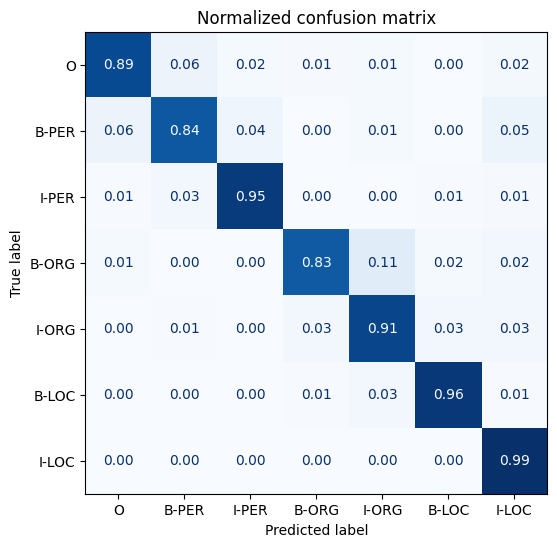

In [84]:
plot_confusion_matrix(df_tokens["labels"], df_tokens["predicted_label"],
                      tags.names)

- 모델이 B-ORG와 I-ORG를 많이 혼동 한다

- 높은 손실을 내는 시퀀스를 알아보자.
- 토큰 시퀀스, 레이블, 손실을 출력 하는 함수

In [85]:
def get_samples(df):
    for _, row in df.iterrows():
        labels, preds, tokens, losses = [], [], [], []
        for i, mask in enumerate(row["attention_mask"]):
            if i not in {0, len(row["attention_mask"])}:
                labels.append(row["labels"][i])
                preds.append(row["predicted_label"][i])
                tokens.append(row["input_tokens"][i])
                losses.append(f"{row['loss'][i]:.2f}")
        df_tmp = pd.DataFrame({"tokens": tokens, "labels": labels,
                               "preds": preds, "losses": losses}).T
        yield df_tmp

In [86]:
df["total_loss"] = df["loss"].apply(sum)
df_tmp = df.sort_values(by="total_loss", ascending=False).head(3)
df_tmp

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens,total_loss
3558,"[0, 242, 5106, 18141, 15020, 5106, 242, 242, 5...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[IGN, O, O, O, IGN, O, O, B-LOC, I-LOC, I-LOC,...","[0.0, 0.00021514962, 0.0002258761, 1.7893946, ...","[O, O, O, B-ORG, O, O, O, O, O, O, O, O, O, O,...","[<s>, ▁', ▁'', ▁Τ, Κ, ▁'', ▁', ▁', ▁'', ▁T, ▁'...",91.741057
5009,"[0, 5106, 1019, 5, 19838, 5106, 152, 75198, 27...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[IGN, B-ORG, IGN, IGN, I-ORG, I-ORG, I-ORG, I-...","[0.0, 9.645274, 0.0, 0.0, 7.875436, 9.03421, 9...","[O, O, O, O, O, O, O, O, O, O, O, O, O, B-ORG,...","[<s>, ▁'', 8, ., ▁Juli, ▁'', ▁:, ▁Protest, cam...",78.851711
4671,"[0, 14098, 145704, 19335, 157955, 91969, 3674,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[IGN, B-PER, I-PER, I-PER, IGN, I-PER, IGN, I-...","[0.0, 6.8751698, 7.0190487, 6.9797935, 0.0, 6....","[I-ORG, B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-O...","[<s>, ▁United, ▁Nations, ▁Multi, dimensional, ...",74.610153


In [87]:
for sample in get_samples(df_tmp):
    display(sample)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
tokens,▁',▁'',▁Τ,Κ,▁'',▁',▁',▁'',▁T,▁'',▁',ri,▁'',▁',k,▁'',▁',ala,</s>
labels,O,O,O,IGN,O,O,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,IGN
preds,O,O,B-ORG,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O
losses,0.00,0.00,1.79,0.00,0.00,0.00,10.20,10.21,8.67,9.72,10.23,0.00,10.00,10.49,0.00,10.06,10.36,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
tokens,▁'',8,.,▁Juli,▁'',▁:,▁Protest,camp,▁auf,▁dem,▁Gelände,▁der,▁Republika,n,ischen,▁Gar,de,</s>
labels,B-ORG,IGN,IGN,I-ORG,I-ORG,I-ORG,I-ORG,IGN,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,IGN,IGN,I-ORG,IGN,IGN
preds,O,O,O,O,O,O,O,O,O,O,O,O,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,O
losses,9.65,0.00,0.00,7.88,9.03,9.05,7.04,0.00,7.07,9.24,7.80,6.91,5.18,0.00,0.00,0.01,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
tokens,▁United,▁Nations,▁Multi,dimensional,▁Integra,ted,▁Stabil,ization,▁Mission,▁in,▁the,▁Central,▁African,▁Republic,</s>
labels,B-PER,I-PER,I-PER,IGN,I-PER,IGN,I-PER,IGN,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG
losses,6.88,7.02,6.98,0.00,6.96,0.00,6.70,0.00,6.67,6.50,6.72,6.79,6.71,6.69,0.00


- label에 문제가 발견
    - 'United Nations' 과 'Central African Republic' 가 PER로 분류 되어 있음
    - '8.Juli' 는 ORG로 분류
    - PAN-X 데이터셋의 레이블이 자동으로 생성 되었고(실버 스텐다드) 자동 방식에 오류가 있었다는 의미 

In [88]:
df_tmp = df.loc[df["input_tokens"].apply(lambda x: u"\u2581(" in x)].head(2)
df_tmp

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens,total_loss
0,"[0, 10699, 11, 15, 16104, 1388, 2]","[1, 1, 1, 1, 1, 1, 1]","[IGN, B-ORG, IGN, I-ORG, I-ORG, I-ORG, IGN]","[0.0, 0.012636709, 0.0, 0.009539733, 0.0064216...","[I-ORG, B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG]","[<s>, ▁Ham, a, ▁(, ▁Unternehmen, ▁), </s>]",0.035944
44,"[0, 75165, 27099, 11, 15, 13212, 76, 1388, 2]","[1, 1, 1, 1, 1, 1, 1, 1, 1]","[IGN, B-LOC, IGN, IGN, I-LOC, I-LOC, IGN, I-LO...","[0.0, 0.036049616, 0.0, 0.0, 0.027491076, 0.02...","[I-LOC, B-LOC, I-LOC, I-LOC, I-LOC, I-LOC, I-L...","[<s>, ▁Kesk, kül, a, ▁(, ▁Mart, na, ▁), </s>]",0.114521


In [89]:
for sample in get_samples(df_tmp):
    display(sample)

,0,1,2,3,4,5
tokens,▁Ham,a,▁(,▁Unternehmen,▁),</s>
labels,B-ORG,IGN,I-ORG,I-ORG,I-ORG,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG
losses,0.01,0.00,0.01,0.01,0.01,0.00


,0,1,2,3,4,5,6,7
tokens,▁Kesk,kül,a,▁(,▁Mart,na,▁),</s>
labels,B-LOC,IGN,IGN,I-LOC,I-LOC,IGN,I-LOC,IGN
preds,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC
losses,0.04,0.00,0.00,0.03,0.03,0.00,0.02,0.00


- 괄호와 슬래시의 손실도 비교적 높다
- 자동으로 레이블을 부여 하다보니 생긴 문제

# 교차 언어 전이
- 독일어로 미세 튜닝 한 XLM-R로 다른 언어 전이 능력 평가
- Trainer 클래스의 predict() 메서드 사용

In [90]:
def get_f1_score(trainer, dataset):
    return trainer.predict(dataset).metrics["test_f1"]

- 이 함수로 테스트 세트의 성능 평가 및 점수를 딕셔너리에 기록

In [91]:
trainer.predict(panx_de_encoded["test"]).metrics["test_f1"]

0.8685236454036951

In [92]:
f1_scores = defaultdict(dict)
f1_scores["de"]["de"] = get_f1_score(trainer, panx_de_encoded["test"])
print(f"[de] 데이터셋에서 [de] 모델의 F1-점수: {f1_scores['de']['de']:.3f}")

[de] 데이터셋에서 [de] 모델의 F1-점수: 0.869


- 평균 점수가 85%은 NER에서는 좋은 수준
- 프랑스어에서 성능 평가

In [93]:
text_fr = "Jeff Dean est informaticien chez Google en Californie"
tag_text(text_fr, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁est,▁informatic,ien,▁chez,▁Google,▁en,▁Cali,for,nie,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,B-ORG,O,B-LOC,I-LOC,I-LOC,O


- 프랑스어 테스트 세트에서 독일어 모델의 성능 검증

In [94]:
def evaluate_lang_performance(lang, trainer):
    panx_ds = encode_panx_dataset(panx_ch[lang])
    return get_f1_score(trainer, panx_ds['test'])

In [95]:
f1_scores["de"]["fr"] = evaluate_lang_performance('fr', trainer)
print(f"[fr] 데이터셋에서 [de] 모델의 F1-점수: {f1_scores['de']['fr']:.3f}")

Map:   0%|          | 0/4580 [00:00<?, ? examples/s]

Map:   0%|          | 0/2290 [00:00<?, ? examples/s]

Map:   0%|          | 0/2290 [00:00<?, ? examples/s]

[fr] 데이터셋에서 [de] 모델의 F1-점수: 0.702


- 독일어 대비 15% 감소
- 이 모델이 레이블링된 프랑스어 샘플을 본 적이 없다는 것을 감안
- 성능의 차이는 언어간 차이에 영향을 받음
- 독일어와 프랑스어는 인도-유럽어족 언어, 게르만어파와 로망스어군에 속함
- 이탈리아어의 성능, 이탈리아어는 프랑스어와 같이 로망스어군

In [96]:
f1_scores["de"]["it"] = evaluate_lang_performance('it', trainer)
print(f"[it] 데이터셋에서 [de] 모델의 F1-점수: {f1_scores['de']['it']:.3f}")

Map:   0%|          | 0/1680 [00:00<?, ? examples/s]

Map:   0%|          | 0/840 [00:00<?, ? examples/s]

Map:   0%|          | 0/840 [00:00<?, ? examples/s]

[it] 데이터셋에서 [de] 모델의 F1-점수: 0.677


- 게르만어파에 속하는 영어

In [97]:
f1_scores["de"]["en"] = evaluate_lang_performance('en', trainer)
print(f"[en] 데이터셋에서 [de] 모델의 F1-점수: {f1_scores['de']['en']:.3f}")

Map:   0%|          | 0/1180 [00:00<?, ? examples/s]

Map:   0%|          | 0/590 [00:00<?, ? examples/s]

Map:   0%|          | 0/590 [00:00<?, ? examples/s]

[en] 데이터셋에서 [de] 모델의 F1-점수: 0.595


- 되려 성능이 가장 낮음

## 제로샷 전이가 유용할 때
- 위 결과가 얼마나 좋은 것인가?
- 단일 언어에서 미세 튜닝한 XLM-R 모델과 비교하면 어떨까?
- 프랑스어 코퍼스로 훈련 세트의 크기를 증가 시키며 XLM-R을 미세 튜닝 하여, 독일어 XLM-R로 교차 언어 전이 한 것과 비교
- 하이퍼파라미터 튜닝
    - TrainingArguments의 logging_steps : 훈련 세트 크기에 맞춰 조정
    - 단일 언어 뭉치에 해당 하는 DatasetDict 객체를 입력
    - num_samples 만큼 샘플링 

In [98]:
def train_on_subset(dataset, num_samples):
    train_ds = dataset['train'].shuffle(seed=42).select(range(num_samples))
    valid_ds = dataset['validation']
    test_ds = dataset['test']
    
    trainer = Trainer(model_init=model_init, 
                      args=training_args,
                     data_collator=data_collator, 
                     compute_metrics=compute_metrics,
                     train_dataset=train_ds,
                     eval_dataset=valid_ds,
                     tokenizer=xlmr_tokenizer)
    trainer.train()
    if training_args.push_to_hub:
        trainer.push_to_hub(commit_message='Training completed!')
    
    f1_score = get_f1_score(trainer, test_ds)
    return pd.DataFrame.from_dict({'num_samples':[len(train_ds)], 
                                  'f1_score':[f1_score]})

- 독일어 처럼, 프랑스어 코퍼스를 입력 ID, 어텐션 마스크, 레이블 ID로 인코딩

In [99]:
panx_fr_encoded = encode_panx_dataset(panx_ch['fr'])

Map:   0%|          | 0/4580 [00:00<?, ? examples/s]

- 250개 샘플로 구성된 작은 훈련 세트로 프랑스어 학습

In [100]:
training_args.push_to_hub = False
metrics_df = train_on_subset(panx_fr_encoded, 250)
metrics_df

Epoch,Training Loss,Validation Loss,F1
1,No log,1.301747,0.015882
2,No log,0.983630,0.199027
3,No log,0.889645,0.365981


,num_samples,f1_score
0,250,0.376701


- 샘플수를 늘려가며 프랑스어 미세 튜닝과 독일어 제로샷 전이 결과 비교

In [101]:
for num_samples in [500, 1000, 2000, 4000]:
    metrics_df =  pd.concat([metrics_df, train_on_subset(panx_fr_encoded, num_samples)])

Epoch,Training Loss,Validation Loss,F1
1,No log,0.929419,0.350091
2,No log,0.591333,0.624513
3,No log,0.511060,0.674393


Epoch,Training Loss,Validation Loss,F1
1,No log,0.578906,0.616978
2,No log,0.426562,0.698691
3,No log,0.378386,0.757447


Epoch,Training Loss,Validation Loss,F1
1,No log,0.426342,0.714631
2,No log,0.361123,0.766349
3,No log,0.337948,0.806155


Epoch,Training Loss,Validation Loss,F1
1,No log,0.354064,0.780158
2,No log,0.286306,0.826962
3,No log,0.276754,0.832749


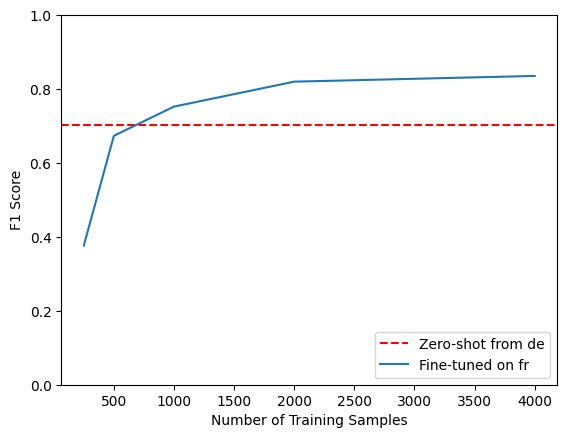

In [102]:
fig, ax = plt.subplots()
ax.axhline(f1_scores["de"]["fr"], ls="--", color="r")
metrics_df.set_index("num_samples").plot(ax=ax)
plt.legend(["Zero-shot from de", "Fine-tuned on fr"], loc="lower right")
plt.ylim((0, 1))
plt.xlabel("Number of Training Samples")
plt.ylabel("F1 Score")
plt.show()

- 샘플이 750개 일때 제로샷 전이를 앞선다.
- 레이블링 비용을 고려 할 때, 나쁘지 않은 성능

## 다국어에서 동시에 미세 튜닝하기
- 다국어를 동시에 미세 튜닝의 이득을 확인 하기 위해
- datasets의 concatenate_datasets() 함수를 사용, 독일어와 프랑스어 합쳐 본다

In [108]:
from datasets import concatenate_datasets

def concatenate_splits(corpora):
    multi_corpus = DatasetDict()
    for split in corpora[0].keys():
        print(split)
        multi_corpus[split] = concatenate_datasets([corpus[split] for corpus in corpora]).shuffle(seed=42)
    return multi_corpus

In [109]:
panx_de_fr_encoded = concatenate_splits([panx_de_encoded, panx_fr_encoded])

train
validation
test


- 앞서와 같은 하이퍼 파리미터 사용

In [110]:
training_args.logging_steps = len(panx_de_fr_encoded['train']) // batch_size
training_args.push_to_hub = False
training_args.output_dir = "xlm-roberta-base-finetuned-panx-de-fr"

In [112]:
trainer = Trainer(model_init=model_init,
                 args=training_args,
                 data_collator=data_collator,
                 compute_metrics=compute_metrics,
                 tokenizer=xlmr_tokenizer,
                 train_dataset=panx_de_fr_encoded['train'],
                 eval_dataset=panx_de_fr_encoded['validation'])

In [114]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.278600,0.186848,0.817671
2,0.143900,0.158996,0.845677
3,0.093400,0.160935,0.859384


TrainOutput(global_step=2145, training_loss=0.17197138646265844, metrics={'train_runtime': 187.9223, 'train_samples_per_second': 273.943, 'train_steps_per_second': 11.414, 'total_flos': 1141075424716416.0, 'train_loss': 0.17197138646265844, 'epoch': 3.0})

In [115]:
for lang in langs:
    f1 = evaluate_lang_performance(lang, trainer)
    print(f"[{lang}] 데이터셋에서 [de-fr] 모델의 F1-점수: {f1:.3f}")

Map:   0%|          | 0/12580 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

[de] 데이터셋에서 [de-fr] 모델의 F1-점수: 0.864


[fr] 데이터셋에서 [de-fr] 모델의 F1-점수: 0.862


[it] 데이터셋에서 [de-fr] 모델의 F1-점수: 0.791


[en] 데이터셋에서 [de-fr] 모델의 F1-점수: 0.674


- trainer를 사용, 각 언어의 테스트 세트에 대한 예측 생성
- 다중 언어 학습이 실제로 얼마나 작동하는지 통찰을 얻을수 있다.

In [125]:
langs

['de', 'fr', 'it', 'en']

In [116]:
corpora = [panx_de_encoded]

# 반복에서 독일어는 제외합니다.
for lang in langs[1:]:
    training_args.output_dir = f"xlm-roberta-base-finetuned-panx-{lang}"
    # 단일 언어 말뭉치에서 미세 튜닝합니다.
    ds_encoded = encode_panx_dataset(panx_ch[lang])
    metrics = train_on_subset(ds_encoded, ds_encoded["train"].num_rows)
    # 딕셔너리에 F1-점수를 모읍니다.
    f1_scores[lang][lang] = metrics["f1_score"][0]
    # 단일 언어 말뭉치를 corpora 리스트에 추가합니다.
    corpora.append(ds_encoded)

Epoch,Training Loss,Validation Loss,F1
1,No log,0.317860,0.784773
2,No log,0.262674,0.832251
3,No log,0.279154,0.847435


Epoch,Training Loss,Validation Loss,F1
1,No log,0.348437,0.740449
2,No log,0.264342,0.789516
3,No log,0.255172,0.822422


Epoch,Training Loss,Validation Loss,F1
1,No log,0.521403,0.568467
2,No log,0.388469,0.674806
3,No log,0.386515,0.708333


In [117]:
corpora_encoded = concatenate_splits(corpora)

train
validation
test


In [119]:
training_args.logging_steps = len(corpora_encoded["train"]) // batch_size
training_args.output_dir = "xlm-roberta-base-finetuned-panx-all"

trainer = Trainer(model_init=model_init, args=training_args,
    data_collator=data_collator, compute_metrics=compute_metrics,
    tokenizer=xlmr_tokenizer, train_dataset=corpora_encoded["train"],
    eval_dataset=corpora_encoded["validation"])

trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.296100,0.211463,0.799814
2,0.157000,0.166482,0.843693
3,0.102100,0.171869,0.854473


TrainOutput(global_step=2505, training_loss=0.18489658523224548, metrics={'train_runtime': 216.1004, 'train_samples_per_second': 277.926, 'train_steps_per_second': 11.592, 'total_flos': 1314063261001344.0, 'train_loss': 0.18489658523224548, 'epoch': 3.0})

In [120]:
for idx, lang in enumerate(langs):
    f1_scores["all"][lang] = get_f1_score(trainer, corpora[idx]["test"])

In [121]:
scores_data = {"de": f1_scores["de"],
               "each": {lang: f1_scores[lang][lang] for lang in langs},
               "all": f1_scores["all"]}
f1_scores_df = pd.DataFrame(scores_data).T.round(4)
f1_scores_df.rename_axis(index="Fine-tune on", columns="Evaluated on",
                         inplace=True)
f1_scores_df

Evaluated on,de,fr,it,en
Fine-tune on,,,,
de,0.8685,0.7020,0.6773,0.5952
each,0.8685,0.8472,0.8211,0.6799
all,0.8662,0.8674,0.8688,0.7730


- 다중 언어 학습은 성능상 큰 이득 제공
- 특히 유사한 언어군에서 데이터가 부족한 언어로 교차 언어 전이를 수행 시 큰 이득 제공
- all 열은 독일어, 프랑스어, 이탈리아어 성능이 비슷
- 일본어 처럼 다른 종류의 텍스트를 다룰 때는 한 어족 내에서 교차 언어 전이 하는 것이 좋다

# 모델 위젯 사용하기

- 로컬에 있는 모델로 pipeline() 함수를 사용할 수도 있지만
- 허브가 제공하는 위젯으로 같은 작업 가능

<img src='./nlp-with-transformers-main/images/chapter04_ner-widget.png'>

# 결론

- 100개 언어에서 사전 훈련된 트랜스포머 모델 XLM-R로 다국어 코퍼스에 대한 NLP 처리
- 독일어에서 프랑스어로 교차 언어 전이는 미세 튜닝에 사용할 레이블링된 샘플이 적을 때만 경쟁력이 있는 방법
- 교차 언어 전이는, 일반적으로 타깃 언어가 베이스 모델의 미세 튜닝에 사용된 언어와 크게 다르지 않을 때 효과적